# **1. Setup** 

####  Import all required modules:

In [226]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import seaborn as sns

#### Read Datasets

In [227]:
train_raw = pd.read_csv('train_data.csv', parse_dates=["startdate"])
test_raw = pd.read_csv('test_data.csv', parse_dates=["startdate"])
submit = pd.read_csv('sample_solution.csv')
target = train_raw['contest-tmp2m-14d__tmp2m']
train_raw

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,nmme0-tmp2m-34w__gfdlflorb0,nmme0-tmp2m-34w__gfdl0,nmme0-tmp2m-34w__nasa0,nmme0-tmp2m-34w__nmme0mean,contest-wind-h10-14d__wind-hgt-10,nmme-tmp2m-56w__cancm3,nmme-tmp2m-56w__cancm4,nmme-tmp2m-56w__ccsm3,nmme-tmp2m-56w__ccsm4,nmme-tmp2m-56w__cfsv2,nmme-tmp2m-56w__gfdl,nmme-tmp2m-56w__gfdlflora,nmme-tmp2m-56w__gfdlflorb,nmme-tmp2m-56w__nasa,nmme-tmp2m-56w__nmmemean,contest-rhum-sig995-14d__rhum,nmme-prate-34w__cancm3,nmme-prate-34w__cancm4,nmme-prate-34w__ccsm3,nmme-prate-34w__ccsm4,nmme-prate-34w__cfsv2,nmme-prate-34w__gfdl,nmme-prate-34w__gfdlflora,nmme-prate-34w__gfdlflorb,nmme-prate-34w__nasa,nmme-prate-34w__nmmemean,contest-wind-h100-14d__wind-hgt-100,nmme0-prate-56w__cancm30,nmme0-prate-56w__cancm40,nmme0-prate-56w__ccsm30,nmme0-prate-56w__ccsm40,nmme0-prate-56w__cfsv20,nmme0-prate-56w__gfdlflora0,nmme0-prate-56w__gfdlflorb0,nmme0-prate-56w__gfdl0,nmme0-prate-56w__nasa0,nmme0-prate-56w__nmme0mean,nmme0-prate-34w__cancm30,nmme0-prate-34w__cancm40,nmme0-prate-34w__ccsm30,nmme0-prate-34w__ccsm40,nmme0-prate-34w__cfsv20,nmme0-prate-34w__gfdlflora0,nmme0-prate-34w__gfdlflorb0,nmme0-prate-34w__gfdl0,nmme0-prate-34w__nasa0,nmme0-prate-34w__nmme0mean,contest-tmp2m-14d__tmp2m,contest-slp-14d__slp,contest-wind-vwnd-925-14d__wind-vwnd-925,nmme-prate-56w__cancm3,nmme-prate-56w__cancm4,nmme-prate-56w__ccsm3,nmme-prate-56w__ccsm4,nmme-prate-56w__cfsv2,nmme-prate-56w__gfdl,nmme-prate-56w__gfdlflora,nmme-prate-56w__gfdlflorb,nmme-prate-56w__nasa,nmme-prate-56w__nmmemean,contest-pres-sfc-gauss-14d__pres,contest-wind-uwnd-250-14d__wind-uwnd-250,nmme-tmp2m-34w__cancm3,nmme-tmp2m-34w__cancm4,nmme-tmp2m-34w__ccsm3,nmme-tmp2m-34w__ccsm4,nmme-tmp2m-34w__cfsv2,nmme-tmp2m-34w__gfdl,nmme-tmp2m-34w__gfdlflora,nmme-tmp2m-34w__gfdlflorb,nmme-tmp2m-34w__nasa,nmme-tmp2m-34w__nmmemean,contest-prwtr-eatm-14d__prwtr,contest-wind-vwnd-250-14d__wind-vwnd-250,contest-precip-14d__precip,contest-wind-h850-14d__wind-hgt-850,contest-wind-uwnd-925-14d__wind-uwnd-925,contest-wind-h500-14d__wind-hgt-500,cancm30,cancm40,ccsm30,ccsm40,cfsv20,gfdlflora0,gfdlflorb0,gfdl0,nasa0,nmme0mean,climateregions__climateregion,elevation__elevation,wind-vwnd-250-2010-1,wind-vwnd-250-2010-2,wind-vwnd-250-2010-3,wind-vwnd-250-2010-4,wind-vwnd-250-2010-5,wind-vwnd-250-2010-6,wind-vwnd-250-2010-7,wind-vwnd-250-2010-8,wind-vwnd-250-2010-9,wind-vwnd-250-2010-10,wind-vwnd-250-2010-11,wind-vwnd-250-2010-12,wind-vwnd-250-2010-13,wind-vwnd-250-2010-14,wind-vwnd-250-2010-15,wind-vwnd-250-2010-16,wind-vwnd-250-2010-17,wind-vwnd-250-2010-18,wind-vwnd-250-2010-19,wind-vwnd-250-2010-20,wind-uwnd-250-2010-1,wind-uwnd-250-2010-2,wind-uwnd-250-2010-3,wind-uwnd-250-2010-4,wind-uwnd-250-2010-5,wind-uwnd-250-2010-6,wind-uwnd-250-2010-7,wind-uwnd-250-2010-8,wind-uwnd-250-2010-9,wind-uwnd-250-2010-10,wind-uwnd-250-2010-11,wind-uwnd-250-2010-12,wind-uwnd-250-2010-13,wind-uwnd-250-2010-14,wind-uwnd-250-2010-15,wind-uwnd-250-2010-16,wind-uwnd-250-2010-17,wind-uwnd-250-2010-18,wind-uwnd-250-2010-19,wind-uwnd-250-2010-20,mjo1d__phase,mjo1d__amplitude,mei__mei,mei__meirank,mei__nip,wind-hgt-850-2010-1,wind-hgt-850-2010-2,wind-hgt-850-2010-3,wind-hgt-850-2010-4,wind-hgt-850-2010-5,wind-hgt-850-2010-6,wind-hgt-850-2010-7,wind-hgt-850-2010-8,wind-hgt-850-2010-9,wind-hgt-850-2010-10,sst-2010-1,sst-2010-2,sst-2010-3,sst-2010-4,sst-2010-5,sst-2010-6,sst-2010-7,sst-2010-8,sst-2010-9,sst-2010-10,wind-hgt-500-2010-1,wind-hgt-500-2010-2,wind-hgt-500-2010-3,wind-hgt-500-2010-4,wind-hgt-500-2010-5,wind-hgt-500-2010-6,wind-hgt-500-2010-7,wind-hgt-500-2010-8,wind-hgt-500-2010-9,wind-hgt-500-2010-10,icec-2010-1,icec-2010-2,icec-2010-3,icec-2010-4,icec-2010-5,icec-2010-6,icec-2010-7,icec-2010-8,icec-2010-9,icec-2010-10,wind-uwnd-925-2010-1,wind-uwnd-925-2010-2,wind-uwnd-925-2010-3,wind-uwnd-925-2010-4,wind-uwnd-925-2010

# **2. EDA**

#### Dataset Description

In [228]:
# Shape of training and test data
print(train_raw.shape)
print(test_raw.shape)
print(target.shape)
print("\nTraining data info:")
print(train_raw.info())
print("\nTest data info:")
test_raw.info()


cols1 = set(train_raw.columns)
cols2 = set(test_raw.columns)
print("####")
diff_cols_train = cols1.difference(cols2)
print(diff_cols_train)

(375734, 246)
(31354, 245)
(375734,)

Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375734 entries, 0 to 375733
Columns: 246 entries, index to wind-vwnd-925-2010-20
dtypes: datetime64[ns](1), float64(240), int64(4), object(1)
memory usage: 705.2+ MB
None

Test data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31354 entries, 0 to 31353
Columns: 245 entries, index to wind-vwnd-925-2010-20
dtypes: datetime64[ns](1), float64(241), int64(2), object(1)
memory usage: 58.6+ MB
####
{'contest-tmp2m-14d__tmp2m'}


In [229]:
non_numeric_columns=train_raw.select_dtypes(include=['object','datetime']).columns #to get non_numeric columns
display(non_numeric_columns)
c1=train_raw.columns.get_loc('startdate')
c2=train_raw.columns.get_loc('climateregions__climateregion')
display(c1,c2)

Index(['startdate', 'climateregions__climateregion'], dtype='object')

3

99

### Preprocessing

#### Find null value columns

In [230]:
# Number of missing values in each column of training data
missing_val_count_by_column = (train_raw.isnull().sum())
l1=missing_val_count_by_column[missing_val_count_by_column > 0]*100/375734
# tr=train_raw.isnull().any()
# missing_val_count_by_column=missing_val_count_by_column.tolist()
# missing_val_count_by_column
l1=l1.index

Since null values form a very less percentage of all the corresponding columns, we can't drop these columns.
#### Let's check by dropping null value rows entirely

In [231]:
reduced_train_raw = train_raw.dropna(axis=0,subset=l1)
# train_raw.isnull().any()
missing_val_count_by_column = (reduced_train_raw.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

Series([], dtype: int64)


#### Another dataset made of imputed columns

In [232]:
my_imputer = SimpleImputer()
train_raw1=train_raw
# train_raw1= train_raw.select_dtypes(exclude=['object','datetime'])
# learnt that it's better to drop those column else leads to ovwrlap while joining and have to use suffix parameters to fix it
train_raw1=train_raw.drop(['startdate', 'climateregions__climateregion'],axis=1)
imputed_train = pd.DataFrame(my_imputer.fit_transform(train_raw1))

# Imputation removed column names; put them back
imputed_train.shape

(375734, 244)

In [233]:
train_raw[non_numeric_columns]

,startdate,climateregions__climateregion
0,2014-09-01,BSh
1,2014-09-02,BSh
2,2014-09-03,BSh
3,2014-09-04,BSh
4,2014-09-05,BSh
...,...,...
375729,2016-08-27,Dfb
375730,2016-08-28,Dfb
375731,2016-08-29,Dfb
375732,2016-08-30,Dfb


In [234]:
missing_val_count_by_column = (imputed_train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])
imputed_train.shape

Series([], dtype: int64)


(375734, 244)

In [235]:
column_names = train_raw1.columns.tolist()
column_names.extend(non_numeric_columns)
# column_names

In [236]:
imputed_train=imputed_train.join(train_raw[non_numeric_columns],how='right')
imputed_train.columns=column_names

In [237]:
print(train_raw.shape)
print(reduced_train_raw.shape)
print(imputed_train.shape)
imputed_train

(375734, 246)
(352604, 246)
(375734, 246)


,index,lat,lon,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,nmme0-tmp2m-34w__gfdlflorb0,nmme0-tmp2m-34w__gfdl0,nmme0-tmp2m-34w__nasa0,nmme0-tmp2m-34w__nmme0mean,contest-wind-h10-14d__wind-hgt-10,nmme-tmp2m-56w__cancm3,nmme-tmp2m-56w__cancm4,nmme-tmp2m-56w__ccsm3,nmme-tmp2m-56w__ccsm4,nmme-tmp2m-56w__cfsv2,nmme-tmp2m-56w__gfdl,nmme-tmp2m-56w__gfdlflora,nmme-tmp2m-56w__gfdlflorb,nmme-tmp2m-56w__nasa,nmme-tmp2m-56w__nmmemean,contest-rhum-sig995-14d__rhum,nmme-prate-34w__cancm3,nmme-prate-34w__cancm4,nmme-prate-34w__ccsm3,nmme-prate-34w__ccsm4,nmme-prate-34w__cfsv2,nmme-prate-34w__gfdl,nmme-prate-34w__gfdlflora,nmme-prate-34w__gfdlflorb,nmme-prate-34w__nasa,nmme-prate-34w__nmmemean,contest-wind-h100-14d__wind-hgt-100,nmme0-prate-56w__cancm30,nmme0-prate-56w__cancm40,nmme0-prate-56w__ccsm30,nmme0-prate-56w__ccsm40,nmme0-prate-56w__cfsv20,nmme0-prate-56w__gfdlflora0,nmme0-prate-56w__gfdlflorb0,nmme0-prate-56w__gfdl0,nmme0-prate-56w__nasa0,nmme0-prate-56w__nmme0mean,nmme0-prate-34w__cancm30,nmme0-prate-34w__cancm40,nmme0-prate-34w__ccsm30,nmme0-prate-34w__ccsm40,nmme0-prate-34w__cfsv20,nmme0-prate-34w__gfdlflora0,nmme0-prate-34w__gfdlflorb0,nmme0-prate-34w__gfdl0,nmme0-prate-34w__nasa0,nmme0-prate-34w__nmme0mean,contest-tmp2m-14d__tmp2m,contest-slp-14d__slp,contest-wind-vwnd-925-14d__wind-vwnd-925,nmme-prate-56w__cancm3,nmme-prate-56w__cancm4,nmme-prate-56w__ccsm3,nmme-prate-56w__ccsm4,nmme-prate-56w__cfsv2,nmme-prate-56w__gfdl,nmme-prate-56w__gfdlflora,nmme-prate-56w__gfdlflorb,nmme-prate-56w__nasa,nmme-prate-56w__nmmemean,contest-pres-sfc-gauss-14d__pres,contest-wind-uwnd-250-14d__wind-uwnd-250,nmme-tmp2m-34w__cancm3,nmme-tmp2m-34w__cancm4,nmme-tmp2m-34w__ccsm3,nmme-tmp2m-34w__ccsm4,nmme-tmp2m-34w__cfsv2,nmme-tmp2m-34w__gfdl,nmme-tmp2m-34w__gfdlflora,nmme-tmp2m-34w__gfdlflorb,nmme-tmp2m-34w__nasa,nmme-tmp2m-34w__nmmemean,contest-prwtr-eatm-14d__prwtr,contest-wind-vwnd-250-14d__wind-vwnd-250,contest-precip-14d__precip,contest-wind-h850-14d__wind-hgt-850,contest-wind-uwnd-925-14d__wind-uwnd-925,contest-wind-h500-14d__wind-hgt-500,cancm30,cancm40,ccsm30,ccsm40,cfsv20,gfdlflora0,gfdlflorb0,gfdl0,nasa0,nmme0mean,elevation__elevation,wind-vwnd-250-2010-1,wind-vwnd-250-2010-2,wind-vwnd-250-2010-3,wind-vwnd-250-2010-4,wind-vwnd-250-2010-5,wind-vwnd-250-2010-6,wind-vwnd-250-2010-7,wind-vwnd-250-2010-8,wind-vwnd-250-2010-9,wind-vwnd-250-2010-10,wind-vwnd-250-2010-11,wind-vwnd-250-2010-12,wind-vwnd-250-2010-13,wind-vwnd-250-2010-14,wind-vwnd-250-2010-15,wind-vwnd-250-2010-16,wind-vwnd-250-2010-17,wind-vwnd-250-2010-18,wind-vwnd-250-2010-19,wind-vwnd-250-2010-20,wind-uwnd-250-2010-1,wind-uwnd-250-2010-2,wind-uwnd-250-2010-3,wind-uwnd-250-2010-4,wind-uwnd-250-2010-5,wind-uwnd-250-2010-6,wind-uwnd-250-2010-7,wind-uwnd-250-2010-8,wind-uwnd-250-2010-9,wind-uwnd-250-2010-10,wind-uwnd-250-2010-11,wind-uwnd-250-2010-12,wind-uwnd-250-2010-13,wind-uwnd-250-2010-14,wind-uwnd-250-2010-15,wind-uwnd-250-2010-16,wind-uwnd-250-2010-17,wind-uwnd-250-2010-18,wind-uwnd-250-2010-19,wind-uwnd-250-2010-20,mjo1d__phase,mjo1d__amplitude,mei__mei,mei__meirank,mei__nip,wind-hgt-850-2010-1,wind-hgt-850-2010-2,wind-hgt-850-2010-3,wind-hgt-850-2010-4,wind-hgt-850-2010-5,wind-hgt-850-2010-6,wind-hgt-850-2010-7,wind-hgt-850-2010-8,wind-hgt-850-2010-9,wind-hgt-850-2010-10,sst-2010-1,sst-2010-2,sst-2010-3,sst-2010-4,sst-2010-5,sst-2010-6,sst-2010-7,sst-2010-8,sst-2010-9,sst-2010-10,wind-hgt-500-2010-1,wind-hgt-500-2010-2,wind-hgt-500-2010-3,wind-hgt-500-2010-4,wind-hgt-500-2010-5,wind-hgt-500-2010-6,wind-hgt-500-2010-7,wind-hgt-500-2010-8,wind-hgt-500-2010-9,wind-hgt-500-2010-10,icec-2010-1,icec-2010-2,icec-2010-3,icec-2010-4,icec-2010-5,icec-2010-6,icec-2010-7,icec-2010-8,icec-2010-9,icec-2010-10,wind-uwnd-925-2010-1,wind-uwnd-925-2010-2,wind-uwnd-925-2010-3,wind-uwnd-925-2010-4,wind-uwnd-925-2010-5,wind-uwnd-925-2010-6,wind-uwnd-925-20

This means that we lost around 23100 fields when we deleted rows with null values.<br />
We can later check after training the model to compare the results of both

### Location analysis

In [238]:
it=imputed_train.groupby('startdate')['climateregions__climateregion'].count()
it

startdate
2014-09-01    514
2014-09-02    514
2014-09-03    514
2014-09-04    514
2014-09-05    514
             ... 
2016-08-27    514
2016-08-28    514
2016-08-29    514
2016-08-30    514
2016-08-31    514
Name: climateregions__climateregion, Length: 731, dtype: int64

In [239]:
tr=test_raw.groupby('startdate')['climateregions__climateregion'].count()
tr

startdate
2022-11-01    514
2022-11-02    514
2022-11-03    514
2022-11-04    514
2022-11-05    514
             ... 
2022-12-27    514
2022-12-28    514
2022-12-29    514
2022-12-30    514
2022-12-31    514
Name: climateregions__climateregion, Length: 61, dtype: int64

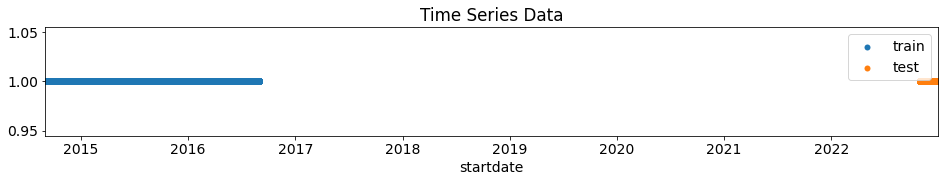

In [240]:
fig, ax = plt.subplots(1,1, figsize=(16,2))
ax.set_title('Time Series Data')
sns.scatterplot(data = imputed_train, x = 'startdate', y = 1, marker='o', linewidth=0, label = 'train')
sns.scatterplot(data = test_raw, x = 'startdate', y = 1, marker='o', linewidth=0, label = 'test')
ax.set_xlim([imputed_train['startdate'].iloc[0], test_raw['startdate'].iloc[-1]])
plt.show()

## 3. Feature Engineernig 